# Preprocessing expression data

This tutorial will demonstrate how to pre-process single-cell raw UMI counts to generate expression matrices that can be used as input to cell-cell communication tools. We recommend the [quality control](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html) chapter in the Single-cell Best Practices book as a starting point for a detailed overview of QC and single-cell RNAseq analysis pipelines in general.

Here we will focus on:
1. Normalization
2. Inter-operability between R and python. 

We demonstrate a typical workflow using a [SingleCellExperiment](https://doi.org/doi:10.18129/B9.bioc.SingleCellExperiment) object. We recommend using SCE because it is less memory intensive and has better compatiblity with LIANA. However, if you prefer [Seurat](https://satijalab.org/seurat/index.html), we have also provided a [supplementary tutorial](./SX_Preprocess_Expression_Seurat) for preprocessing with that tool

For these tutorials, we will use a lung [dataset](https://doi.org/10.1038/s41591-020-0901-9) of 63k immune and epithelial cells across three control, three moderate, and six severe COVID-19 patients.

Details and caveats regarding [batch correction](https://www.nature.com/articles/s41592-018-0254-1), which removes technical variation while preserving biological variation between samples, can be viewed in the [Batch Correction Supplementary Tutorial](./S1_Batch_Correction.ipynb).

In [1]:
suppressPackageStartupMessages({
    library(scater, quietly = TRUE)
    library(scran, quietly = TRUE)
    library(scuttle, quietly = TRUE)
    library(scDblFinder, quietly = TRUE) ## TODO Add to environment.yml

    library(ggplot2, quietly = TRUE)
    library(cowplot, quietly = TRUE)
})

options(timeout=600)

# paths
data.path <- file.path("..", "..", "data")
covid.input.path <- paste0(data.path, 'raw/covid_balf/')

#### Loading

The 12 samples can be downloaded as .h5 files from [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE145926). You can also download the cell metadata from [here](https://raw.githubusercontent.com/zhangzlab/covid_balf/master/all.cell.annotation.meta.txt)

Alternatively, the SCE Object can be downloaded using this [link](https://zenodo.org/record/7593519/files/BALF-COVID19-Liao_et_al-NatMed-2020.rds). See [this notebook](./build_R_objects.ipynb) for how the object was built using the above files. 

In [2]:
# covid_data <- readRDS('/data/hratch/ccc_protocols/raw/BALF-COVID19-Liao_et_al-NatMed-2020_SCE.rds')
covid_data <- readRDS(url('https://zenodo.org/record/7706962/files/BALF-COVID19-Liao_et_al-NatMed-2020_SCE.rds'))

#### Calculate Basic QC metrics

We will calculate some basic QC metrics associated with the library size that will be used for filtering:

In [3]:
covid_data <- scater::addPerCellQC(covid_data)

#### Quality-Control Filtering

Exclude cells that visually do not fall within the normal range of standard QC metrics (see [chapter](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html)) -- fraction of genes in a cell that are mitochondrial, number of unique genes, and total number of genes measured. 

In [4]:
min.features <- 200
min.cells <- 3

sce_counts <- counts(covid_data)

if (min.features > 0) {
  nfeatures <- Matrix::colSums(x = sce_counts > 0)
  sce_counts <- sce_counts[, which(x = nfeatures >= min.features)]
}
# filter genes on the number of cells expressing
if (min.cells > 0) {
  num.cells <- Matrix::rowSums(x = sce_counts > 0)
  sce_counts <- sce_counts[which(x = num.cells >= min.cells), ]
}

covid_data<-covid_data[rownames(sce_counts), colnames(sce_counts)]

Get the fraction of genes that are mitochondrial:

In [5]:
is.mito <- grep("MT-", rownames(covid_data))
per.cell <- scuttle::perCellQCMetrics(covid_data, subsets=list(Mito=is.mito))
colData(covid_data)[['subsets_Mito_percent']] <- per.cell$subsets_Mito_percent

From left to right, plot the total unique features, the total counts, and the fraction of mitochondrial genes in each cell:

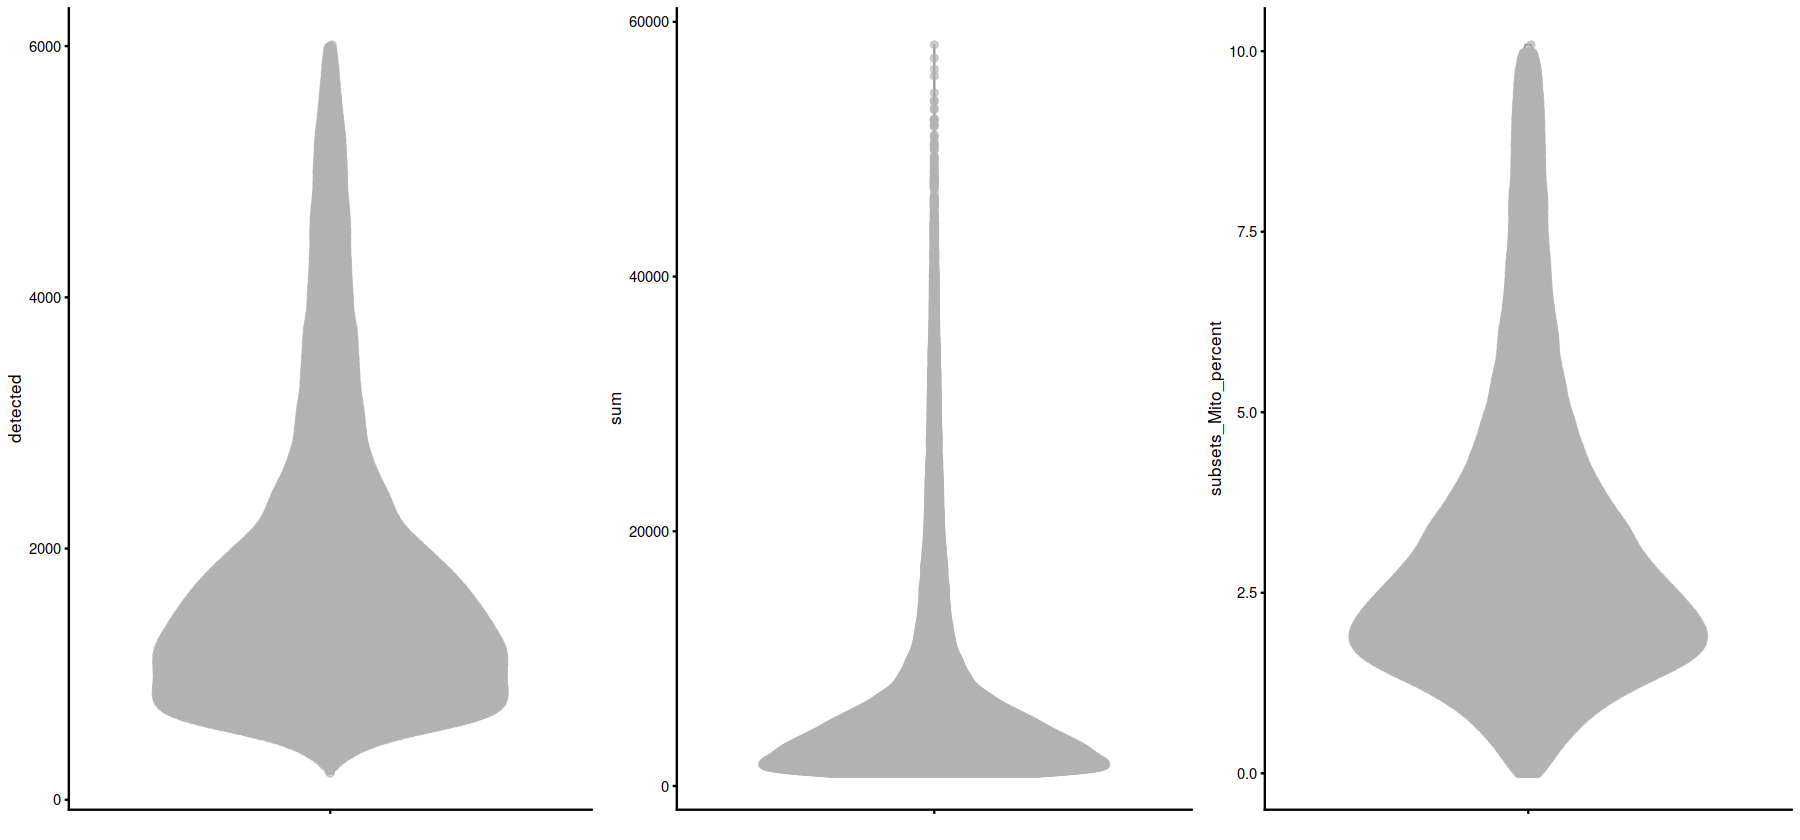

In [6]:
h_ = 7
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

g1A <- scater::plotColData(object = covid_data, y = 'detected')
g1B <- scater::plotColData(object = covid_data, y = 'sum')
g1C <- scater::plotColData(object = covid_data, y = 'subsets_Mito_percent')
g1 <- cowplot::plot_grid(g1A, g1B, g1C, ncol = 3)

g1

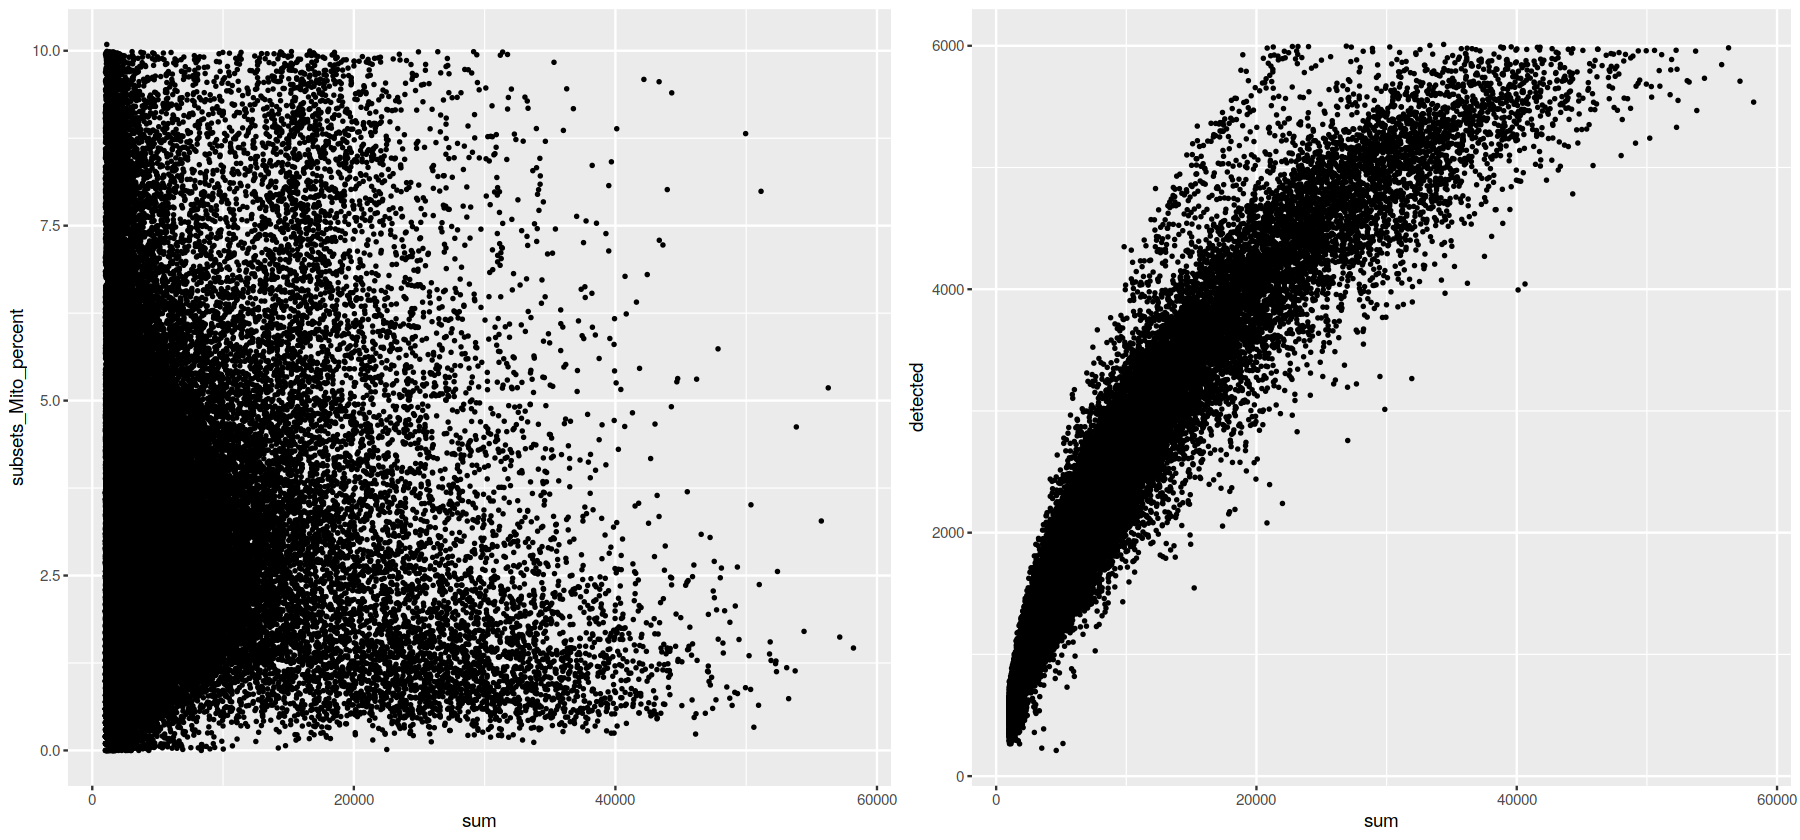

In [7]:
md <- data.frame(covid_data@colData)

g2A <- ggplot(data = md, aes(x = sum, y = subsets_Mito_percent)) + geom_point(size = 0.5)
g2B <- ggplot(data = md, aes(x = sum, y = detected)) + geom_point(size = 0.5)
g2 <- cowplot::plot_grid(g2A, g2B, ncol = 2)
g2

<span style="color:red"> HB: I just noticed the mitochondrial filter threshold is too high to actually do anything  </span>

<span style="color:red"> DD: This is the case for basically all QC steps as the data seems already pre-filtered. We can just do the steps to show them and mention that it is already done to an extend. </span>

We can remove any droplets with high mitochondrial content or those that potentially represent doublets:

In [8]:
covid_data <- covid_data[, colData(covid_data)$subsets_Mito_percent < 15] 
covid_data <- covid_data[, colData(covid_data)$detected < 5500] 

Note that in this case we filter out cells with high total counts, but a best practice approach would be to instead filter out doublets. 
As using different doublet detection techniques in R and Python introduces some differences between the workflows, we will not do this here.

Nevertheless, the code for doublet detection is provided below:

```R
set.seed(100)
covid_data <- scDblFinder(covid_data, samples="sample_new")

```

#### Normalize

For single-cell inference across sample and across cell types, most CCC tools require the library sizes to be comparable. We can use the scuttle function `normalizeCounts` to log- and library-normalize the counts. This function divides each cell by the total counts per cell and multiplies by the median of the total counts per cell. Furthermore, we log1p-transform the data to make it more Gaussian-like, as this is a common assumption for the analyses downstream. Finally, such a normalization maintains non-negative counts, which is important for tensor decomposition.

In [10]:
scale.factor <- 1e4
lib.sizes <- colSums(counts(covid_data)) / scale.factor
assay(covid_data, 'logcounts') <- normalizeCounts(covid_data, size.factors=lib.sizes, log=FALSE, center.size.factors=FALSE)
assay(covid_data, 'logcounts') <- log1p(assay(covid_data, 'logcounts'))

#### Dimensionality Reduction

While dimensionality reduction is not used directly in these tutorials, a number of these steps are necessary to obtain cell group labels when processing your own data. Steps such as filtering for highly variable genes (HVGs) and scaling the data improve dimensionality reudction and clustering results. However, for CCC, we recommend using the entire gene expression matrix unscaled (either raw or library- and log-normalized). Scaling introduces negative counts, which poses challenges for CCC inference or tensor decompsoition. Filtering for HVGs reduces the list of potential ligand-receptor pairs that can be tested for interactions.

This tutorial diverges with its companion tutorial in Python here due to minor algorithmic differences, but since the inputs will be the full expression matrices above, these discrepancies will not affect downstream tutorials. 

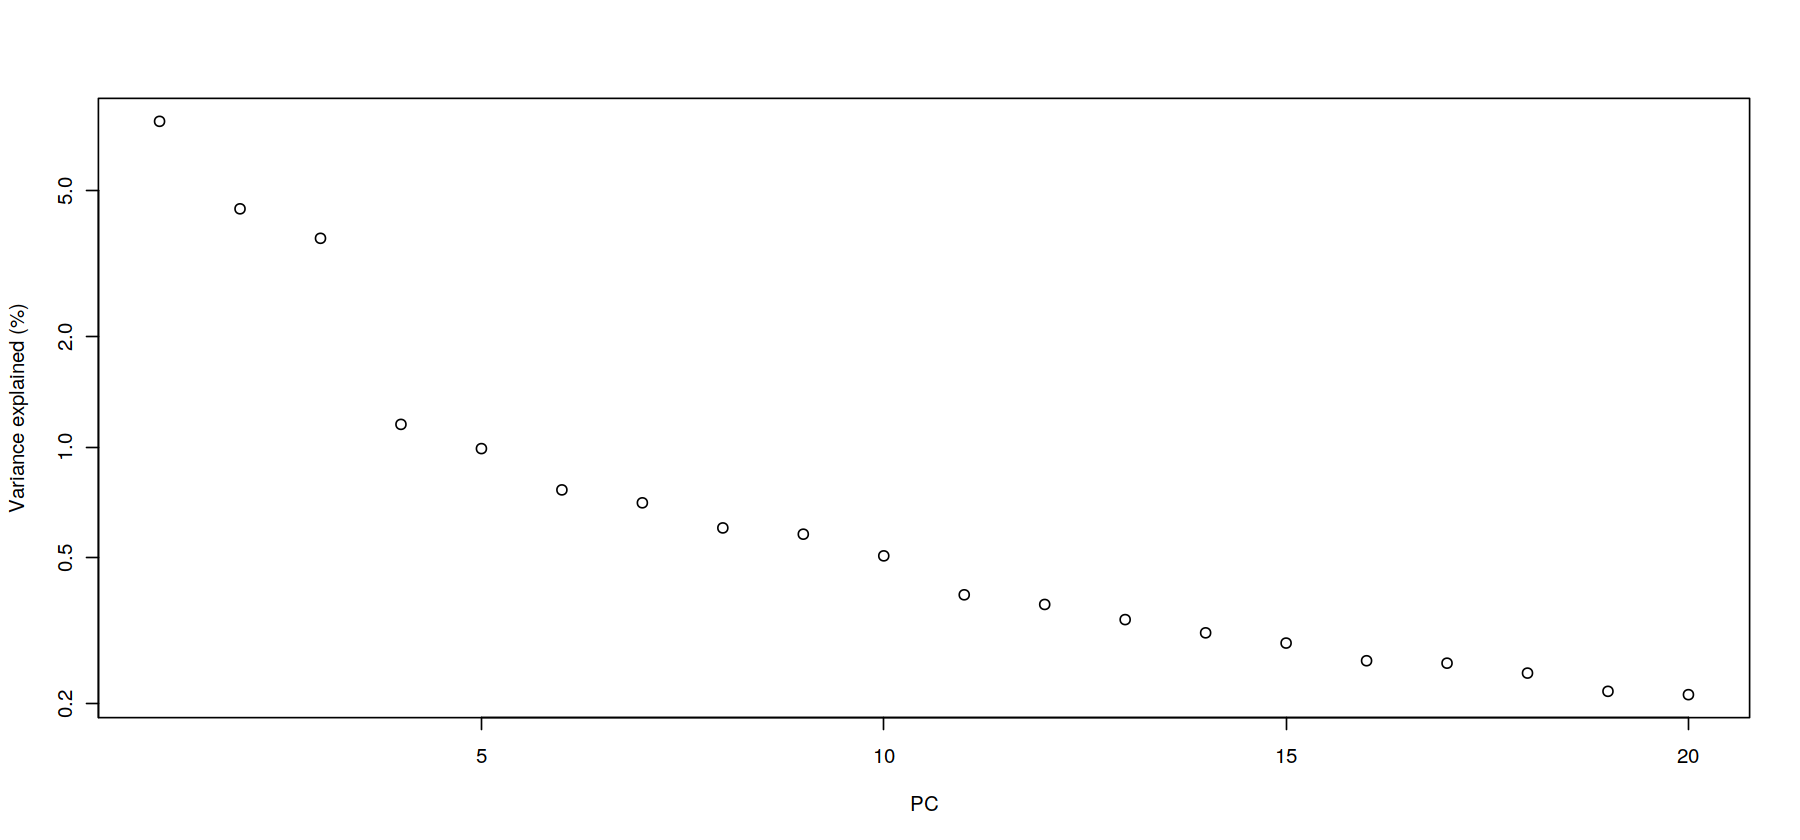

In [11]:
# hvgs<-scran::getTopHVGs(covid_data, n = 2000)

covid_data <- scater::runPCA(covid_data, 
               exprs_values = "logcounts", 
               scale = TRUE, 
               ntop = 2000, 
               ncomponents = 20
               )

percent.var <- attr(reducedDim(covid_data), "percentVar")
plot(percent.var, log="y", xlab="PC", ylab="Variance explained (%)")

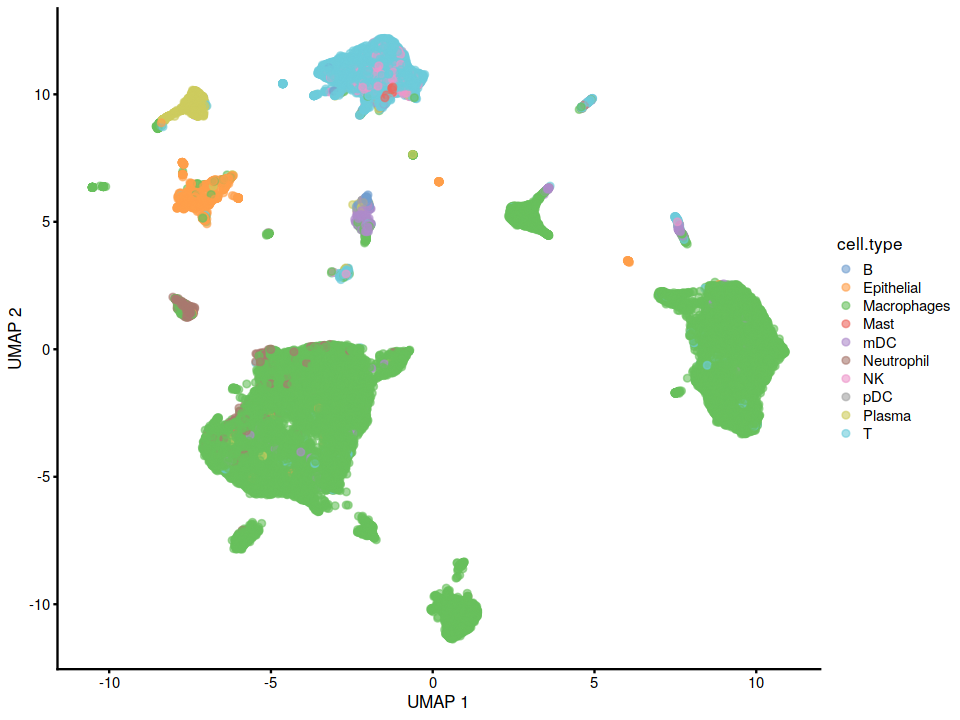

In [12]:
h_ = 8
w_ = 10
options(repr.plot.height=h_, repr.plot.width=w_)

# n.pcs<-20
# scran::buildSNNGraph(covid_data, use.dimred = 'PCA', d = n.pcs, )


covid_data <- scater::runUMAP(covid_data, pca = 20)
scater::plotUMAP(covid_data, colour_by = 'cell.type')

In [14]:
saveRDS(covid_data, file.path(data.path, 'covid_balf_norm.rds'))

## Interoperability

In [ ]:
# interoperability
library(zellkonverter, quietly = TRUE)
library(reticulate, quietly = TRUE)

### to Python

For use in Python, we can convert the Seurat object to an Anndata object using [SeuratDisk](https://mojaveazure.github.io/seurat-disk/articles/convert-anndata.html). The resultant h5ad file contains the same information as the AnnData object generated in the companion Python tutorial. See that tutorial for loading these saved files. 

In [ ]:
data.path<-'/data/hratch/ccc_protocols/interim/'
zellkonverter::writeH5AD(covid_data, 
                         X_name = 'logcounts', 
                         paste0(data.path, 'processed_fromR_toPython.h5ad'))

### from Python

Here, we can load the expression matrices that were generated in the companion python script using AnnData and saved as h5ad files into Seurat:

In [ ]:
data_path = file.path("..", "..", "data")
sce_frompython<-zellkonverter::readH5AD(paste0(data_path, 'processed.h5ad'))